In [1]:
### General ###
import os
import sys
import copy
from tqdm import tqdm
import pickle
import random
import warnings
warnings.filterwarnings("ignore")

### Data Wrangling ###
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime, timedelta

### Data Visualization ###
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

### Machine Learning ###
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import lightgbm as lgb
import xgboost as xgb

### Deep Learning ###
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Tabnet 
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor

# 한글 폰트 설정
from statsmodels import robust
from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

In [2]:
# 데이터 불러오기
train = pd.read_csv('data/trainset.csv')
test = pd.read_csv('data/testset_final.csv')

# susbmssion
submission = pd.read_csv('data/sample_submission_final.csv')

In [3]:
train = train.drop(['매니저주소', '매니저최초가입일', '매니저최초서비스일'], axis=1)

In [4]:
train.shape, test.shape, submission.shape

((23009, 30), (4244, 29), (4244, 2))

In [5]:
train.head()

,SEQ,접수일,접수시각,장기서비스여부,최초서비스일,전체회차,현재회차,서비스일자,서비스시작시간,서비스종료시간,...,매니저생년월일,매니저성별,매니저사용휴대폰,매니저이동방법,근무가능지역,CS교육이수여부,청소교육이수여부,부재중서비스가능여부,추천인여부,매칭성공여부
0,T06420,2019-07-09,NaN,1,2019-07-15,3,3,2019-07-29,9:00:00,13:00:00,...,1956-04-19,0,안드로이드,대중교통,서울,0.0,0.0,1,0,0
1,T15430,2019-07-12,NaN,1,2019-07-15,4,3,2019-08-20,10:00:00,16:00:00,...,1976-06-10,0,안드로이드,대중교통,천안/아산,1.0,1.0,1,0,0
2,T23790,2020-11-18,NaN,1,2020-11-23,10,6,2020-12-11,9:00:00,13:00:00,...,1970-04-05,0,안드로이드,대중교통,천안/아산,0.0,0.0,0,0,0
3,T18740,2020-11-09,NaN,1,2020-11-09,4,4,2020-11-30,9:00:00,14:00:00,...,1956-04-19,0,안드로이드,대중교통,서울,0.0,0.0,1,0,0
4,T08451,2020-02-25,NaN,1,2020-03-31,2,2,2020-04-07,9:00:00,13:00:00,...,1966-03-24,0,안드로이드,대중교통,천안/아산,0.0,0.0,1,0,1


In [6]:
submission.head()

,SEQ,pred
0,T54370,0.5
1,T47892,0.5
2,T56637,0.5
3,T45487,0.5
4,T41995,0.5


## 기본 전처리 및 EDA

In [7]:
# 날짜 처리
train['접수일'] = pd.to_datetime(train['접수일'])
train['최초서비스일'] = pd.to_datetime(train['최초서비스일'])
train['서비스일자'] = pd.to_datetime(train['서비스일자'])
train['고객가입일'] = pd.to_datetime(train['고객가입일'])
train['매니저생년월일'] = pd.to_datetime(train['매니저생년월일']).dt.year

# 시간 처리
train['서비스시작시간'] = pd.to_datetime(train['서비스시작시간'], format='%H:%M:%S')
train['서비스종료시간'] = pd.to_datetime(train['서비스종료시간'], format='%H:%M:%S')
train['서비스시작시간'] = train['서비스시작시간'].dt.hour
train['서비스종료시간'] = train['서비스종료시간'].dt.hour

# 날짜 처리
test['접수일'] = pd.to_datetime(test['접수일'])
test['최초서비스일'] = pd.to_datetime(test['최초서비스일'])
test['서비스일자'] = pd.to_datetime(test['서비스일자'])
test['고객가입일'] = pd.to_datetime(test['고객가입일'])
#test['매니저생년월일'] = pd.to_datetime(test['매니저생년월일'])

# 시간 처리
test['서비스시작시간'] = pd.to_datetime(test['서비스시작시간'], format='%H:%M:%S')
test['서비스종료시간'] = pd.to_datetime(test['서비스종료시간'], format='%H:%M:%S')
test['서비스시작시간'] = test['서비스시작시간'].dt.hour
test['서비스종료시간'] = test['서비스종료시간'].dt.hour

In [8]:
# 접수일 기준
train['접수일_월'] = train['접수일'].dt.month
train['접수일_주차'] = train['접수일'].dt.week
train['접수일_일'] = train['접수일'].dt.day
train['접수일_요일'] = train['접수일'].dt.dayofweek

test['접수일_월'] = test['접수일'].dt.month
test['접수일_주차'] = test['접수일'].dt.week
test['접수일_일'] = test['접수일'].dt.day
test['접수일_요일'] = test['접수일'].dt.dayofweek

# 서비스일자 기준
train['서비스일자_월'] = train['서비스일자'].dt.month
train['서비스일자_주차'] = train['서비스일자'].dt.week
train['서비스일자_일'] = train['서비스일자'].dt.day
train['서비스일자_요일'] = train['서비스일자'].dt.dayofweek

test['서비스일자_월'] = test['서비스일자'].dt.month
test['서비스일자_주차'] = test['서비스일자'].dt.week
test['서비스일자_일'] = test['서비스일자'].dt.day
test['서비스일자_요일'] = test['서비스일자'].dt.dayofweek

In [9]:
train['접수일_fire여부'] = train['접수일_요일'].apply(lambda x : 1 if x >= 4 else 0)
test['접수일_fire여부'] = test['접수일_요일'].apply(lambda x : 1 if x >= 4 else 0)

train['서비스일자_fire여부'] = train['서비스일자_요일'].apply(lambda x : 1 if x >= 4 else 0)
test['서비스일자_fire여부'] = test['서비스일자_요일'].apply(lambda x : 1 if x >= 4 else 0)

In [10]:
train['시작_시간대'] = train['서비스시작시간'].apply(lambda x : '아침' if (x>=7) and (x<=11)
                                               else '점심' if (x>11) and (x<=13)
                                               else '오후' if (x>13) and (x<=19)
                                               else '밤')
test['시작_시간대'] = test['서비스시작시간'].apply(lambda x : '아침' if (x>=7) and (x<=11)
                                               else '점심' if (x>11) and (x<=13)
                                               else '오후' if (x>13) and (x<=19)
                                               else '밤')

train['종료_시간대'] = train['서비스종료시간'].apply(lambda x : '아침' if (x>=7) and (x<=11)
                                               else '점심' if (x>11) and (x<=13)
                                               else '오후' if (x>13) and (x<=19)
                                               else '밤')
test['종료_시간대'] = test['서비스종료시간'].apply(lambda x : '아침' if (x>=7) and (x<=11)
                                               else '점심' if (x>11) and (x<=13)
                                               else '오후' if (x>13) and (x<=19)
                                               else '밤')

In [11]:
### 처음에 일단 numeric만 봐
train['서비스시간'] = train['서비스종료시간'] - train['서비스시작시간']
test['서비스시간'] = test['서비스종료시간'] - test['서비스시작시간']

train['회차사용비율'] = train['현재회차'] / train['전체회차']
test['회차사용비율'] = test['현재회차'] / test['전체회차']

train['매니저나이'] = train['매니저생년월일'].apply(lambda x : 2021 - x)
test['매니저나이'] = test['매니저생년월일'].apply(lambda x : 2021 - x)

train['최초서비스일_접수일'] = train['최초서비스일'] - train['접수일']
test['최초서비스일_접수일'] = test['최초서비스일'] - test['접수일']

train['서비스일자_최초서비스일'] = train['서비스일자'] - train['최초서비스일']
test['서비스일자_최초서비스일'] = test['서비스일자'] - test['최초서비스일']

In [12]:
# timedelta 형식 feature -> int형식으로
train['최초서비스일_접수일'] = train['최초서비스일_접수일'].dt.days.astype('int16')
test['최초서비스일_접수일'] = test['최초서비스일_접수일'].dt.days.astype('int16')

train['서비스일자_최초서비스일'] = train['서비스일자_최초서비스일'].dt.days.astype('int16')
test['서비스일자_최초서비스일'] = test['서비스일자_최초서비스일'].dt.days.astype('int16')

In [13]:
train['서비스사용_term'] = (train['서비스일자_최초서비스일'] / train['현재회차']).fillna(0)
test['서비스사용_term'] = (test['서비스일자_최초서비스일'] / test['현재회차']).fillna(0)

In [14]:
train['서비스사용_term_ratio'] = (train['서비스일자_최초서비스일'] / (train['최초서비스일_접수일']+1)).fillna(0)
test['서비스사용_term_ratio'] = (test['서비스일자_최초서비스일'] / (test['최초서비스일_접수일']+1)).fillna(0)

In [15]:
train['시간추가여부'] = train['서비스시간'].apply(lambda x : 1 if x not in ([2, 4, 6, 8, 10]) else 0)
test['시간추가여부'] = test['서비스시간'].apply(lambda x : 1 if x not in ([2, 4, 6, 8, 10]) else 0)

In [16]:
train['서비스종료시작_ratio'] = train['서비스시작시간'] / train['서비스종료시간']
test['서비스종료시작_ratio'] = test['서비스시작시간'] / test['서비스종료시간']

In [17]:
# 고객 열 결측치 개수
na_sum = []
for i in range (0, train.shape[0], 1):
    na_all = train.iloc[i:i+1, 3:20].isna().sum().sum()
    na_sum.append(na_all)

na_sum_te = []
for i in range (0, test.shape[0], 1):
    na_all = test.iloc[i:i+1, 3:20].isna().sum().sum()
    na_sum_te.append(na_all)

na_df = pd.DataFrame(na_sum)
na_df.columns = ['na값']

na_df_te = pd.DataFrame(na_sum_te)
na_df_te.columns = ['na값']

train = pd.concat([train, na_df], axis=1)
test = pd.concat([test, na_df_te], axis=1)

In [18]:
# 고객 정보 중 NA값 비율
train['NA값비율'] = train['na값'] / 17
test['NA값비율'] = test['na값'] / 17

In [19]:
train.iloc[:, :20].head(1)

,SEQ,접수일,접수시각,장기서비스여부,최초서비스일,전체회차,현재회차,서비스일자,서비스시작시간,서비스종료시간,기존고객여부,결재형태,서비스주소,주거형태,평수,고객가입일,반려동물,부재중여부,우선청소,쿠폰사용여부
0,T06420,2019-07-09,NaN,1,2019-07-15,3,3,2019-07-29,9,13,1,무통장입금,충남 천안시,일반주택,NaN,2019-04-22,NaN,NaN,NaN,0


In [20]:
train.iloc[:, 20:40].head(1)

,매니저생년월일,매니저성별,매니저사용휴대폰,매니저이동방법,근무가능지역,CS교육이수여부,청소교육이수여부,부재중서비스가능여부,추천인여부,매칭성공여부,접수일_월,접수일_주차,접수일_일,접수일_요일,서비스일자_월,서비스일자_주차,서비스일자_일,서비스일자_요일,접수일_fire여부,서비스일자_fire여부
0,1956,0,안드로이드,대중교통,서울,0.0,0.0,1,0,0,7,28,9,1,7,31,29,0,0,0


In [21]:
train.iloc[:, 40:].head(1)

,시작_시간대,종료_시간대,서비스시간,회차사용비율,매니저나이,최초서비스일_접수일,서비스일자_최초서비스일,서비스사용_term,서비스사용_term_ratio,시간추가여부,서비스종료시작_ratio,na값,NA값비율
0,아침,점심,4,1.0,65,6,14,4.666667,2.0,0,0.692308,4,0.235294


In [22]:
# train, test셋의 구성이 다른 피처 처리 - 결제형태, 서비스주소
train['서비스주소'] = train.서비스주소.str[:2]
train['결재형태'] = train.결재형태.replace('미수', np.NaN) # or 드랍 
                               
test['서비스주소'] = test.서비스주소.str[:2]
test['결재형태'] = test.결재형태.replace('미수', np.NaN) # or 드랍

In [23]:
train['반려동물'] = train['반려동물'].apply(lambda x: 0 if x=='없음' else 1 
                                    if x in ['개', '고양이', '기타', '개,고양이', '고양이,기타', '개,기타'] else x)
test['반려동물'] = test['반려동물'].apply(lambda x: 0 if x=='없음' else 1 
                                  if x in ['개', '고양이', '기타', '개,고양이', '고양이,기타', '개,기타'] else x)

In [24]:
### train, test셋의 구성이 다른 피처 처리
print(set(train['결재형태'].unique()) - set(test['결재형태'].unique()))
print(set(test['결재형태'].unique()) - set(train['결재형태'].unique()))

# 앞에 두글자만 따던지 해야할듯
print(set(train['서비스주소'].unique()) - set(test['서비스주소'].unique()))
print(set(test['서비스주소'].unique()) - set(train['서비스주소'].unique()))

set()
set()
{'경남'}
set()


## 데이터 셋 세팅

In [25]:
train.columns

Index(['SEQ', '접수일', '접수시각', '장기서비스여부', '최초서비스일', '전체회차', '현재회차', '서비스일자',
       '서비스시작시간', '서비스종료시간', '기존고객여부', '결재형태', '서비스주소', '주거형태', '평수', '고객가입일',
       '반려동물', '부재중여부', '우선청소', '쿠폰사용여부', '매니저생년월일', '매니저성별', '매니저사용휴대폰',
       '매니저이동방법', '근무가능지역', 'CS교육이수여부', '청소교육이수여부', '부재중서비스가능여부', '추천인여부',
       '매칭성공여부', '접수일_월', '접수일_주차', '접수일_일', '접수일_요일', '서비스일자_월', '서비스일자_주차',
       '서비스일자_일', '서비스일자_요일', '접수일_fire여부', '서비스일자_fire여부', '시작_시간대', '종료_시간대',
       '서비스시간', '회차사용비율', '매니저나이', '최초서비스일_접수일', '서비스일자_최초서비스일', '서비스사용_term',
       '서비스사용_term_ratio', '시간추가여부', '서비스종료시작_ratio', 'na값', 'NA값비율'],
      dtype='object')

In [26]:
features = ['장기서비스여부', '전체회차', '현재회차', '서비스시작시간', '서비스종료시간', '기존고객여부', '결재형태', 
            '서비스주소', '주거형태', '평수', '반려동물', '부재중여부', '우선청소', '쿠폰사용여부', '매니저사용휴대폰',
            '매니저이동방법', '근무가능지역', '청소교육이수여부', '부재중서비스가능여부', '추천인여부',
            '접수일_fire여부', '서비스일자_fire여부', '서비스시간', '회차사용비율', '매니저나이', 
            '최초서비스일_접수일', '서비스일자_최초서비스일', '서비스사용_term', '서비스사용_term_ratio', '시간추가여부', 
            '서비스종료시작_ratio', 'na값']

In [27]:
ftr = train[features]
ftr_te = test[features]
target = train['매칭성공여부']

## 결측치 처리

In [28]:
# 반려동물: 결측치 비율이 12%이지만, 대부분이 '없음'(없음 > 개 > 고양이 > 기타) -> '대체?
# 매니저사용휴대폰: 결측치 비율이 12%이며, 대부분이 '안드로이드' (안드로이드 > 기타 > ios) -> 최빈값인 '안드로이드'로 대체? or '기타'로 대체? 
# 매니저이동방법: 결측치 비율이 1%이며, 대부분이 '대중교통'이므로 최빈값인 '대중교통'으로 대체!
# CS교육이수여부: 결측치 비율이 12%이며, 대부분이 '미이수'이므로 최빈값인 '미이수'로 대체!
# 청소교육이수여부: 결측치 비율이 12%이며, 대부분이 '미이수'이므로 최빈값인 '미이수'로 대체!

imputer_col = ['반려동물']#, '매니저사용휴대폰', '매니저이동방법', 'CS교육이수여부', '청소교육이수여부']

for col in imputer_col:
    ftr.loc[ftr[col].isna(), col] = ftr[col].mode()[0]
    ftr_te.loc[ftr_te[col].isna(), col] = ftr_te[col].mode()[0]

In [29]:
# 한글로 구성되어 있는 피처 Label Encoding
from sklearn.preprocessing import LabelEncoder
lst = ['주거형태', '평수', '우선청소', '매니저사용휴대폰', '매니저이동방법', '근무가능지역', '결재형태', '서비스주소']

for i in lst:
    le = LabelEncoder()
    ftr[i] = le.fit_transform(ftr[i])
    ftr_te[i] = le.transform(ftr_te[i])

In [30]:
ftr['평수'] = ftr.평수.replace(4, np.NaN)
ftr['우선청소'] = ftr.우선청소.replace(5, np.NaN)
ftr['매니저사용휴대폰'] = ftr.매니저사용휴대폰.replace(3, np.NaN)
ftr['매니저이동방법'] = ftr.매니저이동방법.replace(2, np.NaN)
ftr['청소교육이수여부'] = ftr.청소교육이수여부.replace(2, np.NaN)

In [31]:
ftr.shape, ftr_te.shape, target.shape

((23009, 32), (4244, 32), (23009,))

In [32]:
ftr.columns

Index(['장기서비스여부', '전체회차', '현재회차', '서비스시작시간', '서비스종료시간', '기존고객여부', '결재형태',
       '서비스주소', '주거형태', '평수', '반려동물', '부재중여부', '우선청소', '쿠폰사용여부', '매니저사용휴대폰',
       '매니저이동방법', '근무가능지역', '청소교육이수여부', '부재중서비스가능여부', '추천인여부', '접수일_fire여부',
       '서비스일자_fire여부', '서비스시간', '회차사용비율', '매니저나이', '최초서비스일_접수일',
       '서비스일자_최초서비스일', '서비스사용_term', '서비스사용_term_ratio', '시간추가여부',
       '서비스종료시작_ratio', 'na값'],
      dtype='object')

In [33]:
cat_features = ['장기서비스여부', '서비스시작시간', '서비스종료시간', '기존고객여부', '결재형태', '서비스주소', '주거형태', '평수', '반려동물', '부재중여부', 
                '우선청소', '쿠폰사용여부', '매니저사용휴대폰', '매니저이동방법', '근무가능지역', 
                '청소교육이수여부', '부재중서비스가능여부', '추천인여부', '접수일_fire여부', '서비스일자_fire여부', 
                '시간추가여부']

In [34]:
cat_lst = [0, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 29]

In [35]:
from missingpy import MissForest
imputer = MissForest(random_state=0)
ftr_imputed = imputer.fit_transform(ftr, cat_vars=cat_lst)
ftr_te_imputed = imputer.transform(ftr_te)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


In [36]:
ftr_imputed = pd.DataFrame(ftr_imputed)
ftr_imputed.columns = ftr.columns

ftr_te_imputed = pd.DataFrame(ftr_te_imputed)
ftr_te_imputed.columns = ftr_te.columns

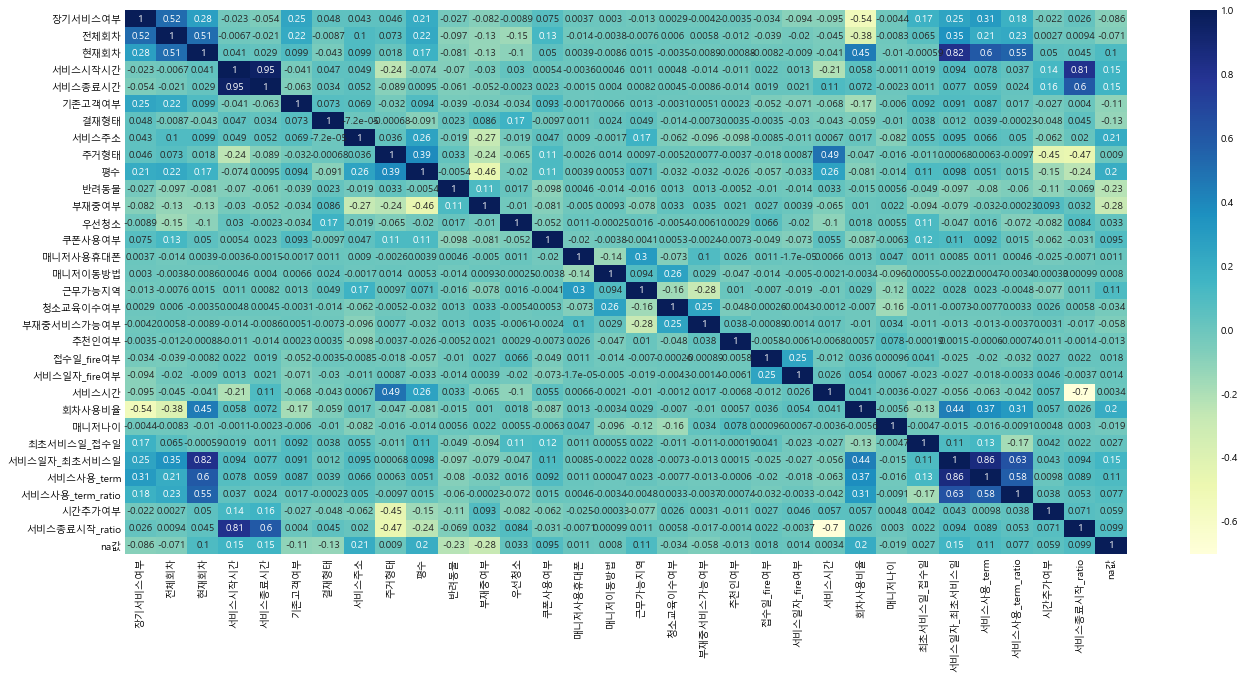

In [37]:
plt.figure(figsize=(20, 10))
sns.heatmap(ftr_imputed.corr(), annot=True, cmap="YlGnBu")
plt.show()

## 서비스특징

In [38]:
ftr_imputed.iloc[:, :20].head(3)

,장기서비스여부,전체회차,현재회차,서비스시작시간,서비스종료시간,기존고객여부,결재형태,서비스주소,주거형태,평수,반려동물,부재중여부,우선청소,쿠폰사용여부,매니저사용휴대폰,매니저이동방법,근무가능지역,청소교육이수여부,부재중서비스가능여부,추천인여부
0,1.0,3.0,3.0,9.0,13.0,1.0,1.0,6.0,1.0,3.0,0.0,0.0,4.0,0.0,2.0,0.0,3.0,0.0,1.0,0.0
1,1.0,4.0,3.0,10.0,16.0,1.0,1.0,6.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,6.0,1.0,1.0,0.0
2,1.0,10.0,6.0,9.0,13.0,1.0,2.0,6.0,1.0,3.0,0.0,0.0,1.0,0.0,2.0,0.0,6.0,0.0,0.0,0.0


In [39]:
ftr_imputed.iloc[:, 20:].head(3)

,접수일_fire여부,서비스일자_fire여부,서비스시간,회차사용비율,매니저나이,최초서비스일_접수일,서비스일자_최초서비스일,서비스사용_term,서비스사용_term_ratio,시간추가여부,서비스종료시작_ratio,na값
0,0.0,0.0,4.0,1.00,65.0,6.0,14.0,4.666667,2.0,0.0,0.692308,4.0
1,1.0,0.0,6.0,0.75,45.0,3.0,36.0,12.000000,9.0,0.0,0.625000,3.0
2,0.0,1.0,4.0,0.60,51.0,5.0,18.0,3.000000,3.0,0.0,0.692308,1.0


In [40]:
ftr_imputed[cat_features] = ftr_imputed[cat_features].astype(str)
ftr_te_imputed[cat_features] = ftr_te_imputed[cat_features].astype(str)

In [41]:
ftr_imputed['서비스특징'] = ftr_imputed['기존고객여부'] + '_' + ftr_imputed['결재형태'] + '_' + ftr_imputed['서비스주소'] + '_' \
+ ftr_imputed['주거형태'] + '_' + ftr_imputed['평수'] + '_' + ftr_imputed['반려동물'] + '_' +  ftr_imputed['부재중여부'] + '_' \
+ ftr_imputed['우선청소'] + '_' + ftr_imputed['매니저사용휴대폰'] + '_' + ftr_imputed['매니저이동방법'] + '_' \
+ ftr_imputed['근무가능지역'] + '_' + ftr_imputed['청소교육이수여부'] + '_' + ftr_imputed['부재중서비스가능여부'] + '_' \
+ ftr_imputed['추천인여부'] + '_' + ftr_imputed['시간추가여부'] + '_' + ftr_imputed['매니저나이'].astype(str)

ftr_te_imputed['서비스특징'] = ftr_te_imputed['기존고객여부'] + '_' + ftr_te_imputed['결재형태'] + '_' + ftr_te_imputed['서비스주소'] + '_' \
+ ftr_te_imputed['주거형태'] + '_' + ftr_te_imputed['평수'] + '_' + ftr_te_imputed['반려동물'] + '_' +  ftr_te_imputed['부재중여부'] + '_' \
+ ftr_te_imputed['우선청소'] + '_' + ftr_te_imputed['매니저사용휴대폰'] + '_' + ftr_te_imputed['매니저이동방법'] + '_' \
+ ftr_te_imputed['근무가능지역'] + '_' + ftr_te_imputed['청소교육이수여부'] + '_' + ftr_te_imputed['부재중서비스가능여부'] + '_' \
+ ftr_te_imputed['추천인여부'] + '_' + ftr_te_imputed['시간추가여부'] + '_' + ftr_te_imputed['매니저나이'].astype(str)

In [374]:
import random

train_data = list(ftr_imputed['서비스특징'].unique())
test_data = list(ftr_te_imputed['서비스특징'].unique())

In [375]:
test_data[0]

'1.0_2.0_6.0_1.0_3.0_1.0_0.0_3.0_2.0_0.0_5.0_0.0_1.0_0.0_0.0_60.0'

In [376]:
from gensim.models.fasttext import FastText

In [377]:
model = FastText(sentences=train_data, size=30, window=7, min_count=1, sg=1)

In [378]:
model.train(sentences=train_data, epochs=5, total_examples=model.corpus_count, 
            total_words=model.corpus_total_words)

In [379]:
train_mean_vector = []
for words in tqdm(train_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += model.wv[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    train_mean_vector.append(tmp)
train_mean_vector = np.array(train_mean_vector)

100%|████████████████████████████████████████████████████████████████████████████| 8181/8181 [00:01<00:00, 5063.25it/s]


In [380]:
test_mean_vector = []
for words in tqdm(test_data):
    tmp = np.zeros(30)
    cnt = 0
    for word in words:
        try:
            tmp += model.wv[word]
            cnt += 1
        except:
            pass
    tmp /= cnt
    test_mean_vector.append(tmp)
test_mean_vector = np.array(test_mean_vector)

100%|████████████████████████████████████████████████████████████████████████████| 2864/2864 [00:00<00:00, 5231.98it/s]


In [381]:
train_mean_vector = pd.DataFrame(train_mean_vector)
train_mean_vector.columns = train_mean_vector.columns.astype(str) + "_service"

test_mean_vector = pd.DataFrame(test_mean_vector)
test_mean_vector.columns = test_mean_vector.columns.astype(str) + "_service"

In [382]:
train_mean_vector['서비스특징'] = train_data
test_mean_vector['서비스특징'] = test_data

In [383]:
ftr_imputed = ftr_imputed.merge(train_mean_vector, on='서비스특징', how='left').drop('서비스특징', axis=1)
ftr_te_imputed = ftr_te_imputed.merge(test_mean_vector, on='서비스특징', how='left').drop('서비스특징', axis=1)

In [384]:
ftr_imputed.shape, ftr_te_imputed.shape

((23009, 62), (4244, 62))

## 스케일링

In [385]:
num_features = list(set(ftr.columns) - set(cat_features) - set((train_mean_vector.columns)))

In [386]:
num_features

['서비스사용_term_ratio',
 '최초서비스일_접수일',
 '서비스시간',
 '서비스종료시작_ratio',
 'na값',
 '서비스사용_term',
 '회차사용비율',
 '현재회차',
 '서비스일자_최초서비스일',
 '전체회차',
 '매니저나이']

### Gauss rank
* https://github.com/aldente0630/gauss_rank_scaler

In [387]:
import numpy as np
from joblib import Parallel, delayed
from scipy.interpolate import interp1d
from scipy.special import erf, erfinv
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import FLOAT_DTYPES, check_array, check_is_fitted

class GaussRankScaler(BaseEstimator, TransformerMixin):
    """Transform features by scaling each feature to a normal distribution.
    Parameters
        ----------
        epsilon : float, optional, default 1e-4
            A small amount added to the lower bound or subtracted
            from the upper bound. This value prevents infinite number
            from occurring when applying the inverse error function.
        copy : boolean, optional, default True
            If False, try to avoid a copy and do inplace scaling instead.
            This is not guaranteed to always work inplace; e.g. if the data is
            not a NumPy array, a copy may still be returned.
        n_jobs : int or None, optional, default None
            Number of jobs to run in parallel.
            ``None`` means 1 and ``-1`` means using all processors.
        interp_kind : str or int, optional, default 'linear'
           Specifies the kind of interpolation as a string
            ('linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic',
            'previous', 'next', where 'zero', 'slinear', 'quadratic' and 'cubic'
            refer to a spline interpolation of zeroth, first, second or third
            order; 'previous' and 'next' simply return the previous or next value
            of the point) or as an integer specifying the order of the spline
            interpolator to use.
        interp_copy : bool, optional, default False
            If True, the interpolation function makes internal copies of x and y.
            If False, references to `x` and `y` are used.
        Attributes
        ----------
        interp_func_ : list
            The interpolation function for each feature in the training set.
        """

    def __init__(self, epsilon=1e-4, copy=True, n_jobs=None, interp_kind='linear', interp_copy=False):
        self.epsilon = epsilon
        self.copy = copy
        self.interp_kind = interp_kind
        self.interp_copy = interp_copy
        self.fill_value = 'extrapolate'
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        """Fit interpolation function to link rank with original data for future scaling
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The data used to fit interpolation function for later scaling along the features axis.
        y
            Ignored
        """
        X = check_array(X, copy=self.copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        self.interp_func_ = Parallel(n_jobs=self.n_jobs)(delayed(self._fit)(x) for x in X.T)
        return self

    def _fit(self, x):
        x = self.drop_duplicates(x)
        rank = np.argsort(np.argsort(x))
        bound = 1.0 - self.epsilon
        factor = np.max(rank) / 2.0 * bound
        scaled_rank = np.clip(rank / factor - bound, -bound, bound)
        return interp1d(
            x, scaled_rank, kind=self.interp_kind, copy=self.interp_copy, fill_value=self.fill_value)

    def transform(self, X, copy=None):
        """Scale the data with the Gauss Rank algorithm
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The data used to scale along the features axis.
        copy : bool, optional (default: None)
            Copy the input X or not.
        """
        check_is_fitted(self, 'interp_func_')

        copy = copy if copy is not None else self.copy
        X = check_array(X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        X = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self._transform)(i, x) for i, x in enumerate(X.T))).T
        return X

    def _transform(self, i, x):
        return erfinv(self.interp_func_[i](x))

    def inverse_transform(self, X, copy=None):
        """Scale back the data to the original representation
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data used to scale along the features axis.
        copy : bool, optional (default: None)
            Copy the input X or not.
        """
        check_is_fitted(self, 'interp_func_')

        copy = copy if copy is not None else self.copy
        X = check_array(X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        X = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self._inverse_transform)(i, x) for i, x in enumerate(X.T))).T
        return X

    def _inverse_transform(self, i, x):
        inv_interp_func = interp1d(self.interp_func_[i].y, self.interp_func_[i].x, kind=self.interp_kind,
                                   copy=self.interp_copy, fill_value=self.fill_value)
        return inv_interp_func(erf(x))

    @staticmethod
    def drop_duplicates(x):
        is_unique = np.zeros_like(x, dtype=bool)
        is_unique[np.unique(x, return_index=True)[1]] = True
        return x[is_unique]

In [388]:
scaler = GaussRankScaler()
ftr_imputed[num_features] = pd.DataFrame(scaler.fit_transform(ftr_imputed[num_features]))
ftr_te_imputed[num_features] = pd.DataFrame(scaler.transform(ftr_te_imputed[num_features]))

ftr_imputed[num_features].columns = ftr[num_features].columns
ftr_te_imputed[num_features].columns = ftr[num_features].columns

In [389]:
ftr_imputed.head()

,장기서비스여부,전체회차,현재회차,서비스시작시간,서비스종료시간,기존고객여부,결재형태,서비스주소,주거형태,평수,...,20_service,21_service,22_service,23_service,24_service,25_service,26_service,27_service,28_service,29_service
0,1.0,-0.594939,-0.540560,9.0,13.0,1.0,1.0,6.0,1.0,3.0,...,-0.017359,0.023589,0.039019,0.047217,0.021809,0.096729,0.041823,0.006875,-0.037889,-0.016619
1,1.0,-0.370644,-0.540560,10.0,16.0,1.0,1.0,6.0,1.0,2.0,...,-0.018396,0.021471,0.037031,0.047266,0.018514,0.091852,0.041786,0.006574,-0.035604,-0.017134
2,1.0,0.906758,0.098979,9.0,13.0,1.0,2.0,6.0,1.0,3.0,...,-0.018782,0.022662,0.036000,0.049254,0.017934,0.091880,0.042780,0.006325,-0.037013,-0.015106
3,1.0,-0.370644,-0.304408,9.0,14.0,1.0,1.0,5.0,1.0,2.0,...,-0.018180,0.016551,0.038884,0.050149,0.019464,0.092648,0.042649,0.005261,-0.038695,-0.014573
4,1.0,-0.905952,-0.862895,9.0,13.0,1.0,1.0,6.0,1.0,3.0,...,-0.016713,0.020442,0.038032,0.045715,0.022562,0.093948,0.041834,0.006587,-0.036507,-0.016863


## 모델링

In [390]:
from lightgbm import LGBMClassifier
from xgboost import XGBRFClassifier
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from ngboost import NGBRegressor
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score

In [391]:
kf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

In [392]:
cat_features = ['장기서비스여부', '서비스시작시간', '서비스종료시간', '기존고객여부', '결재형태', '서비스주소', '주거형태', '평수', '반려동물', '부재중여부', 
                '우선청소', '쿠폰사용여부', '매니저사용휴대폰', '매니저이동방법', '근무가능지역', 
                '청소교육이수여부', '부재중서비스가능여부', '추천인여부', '접수일_fire여부', '서비스일자_fire여부', 
                '시간추가여부']

In [393]:
ftr_imputed.shape, target.shape, ftr_te_imputed.shape

((23009, 62), (23009,), (4244, 62))

### RFE

In [394]:
from sklearn.feature_selection import RFECV

In [395]:
model = LGBMClassifier(random_state=0, n_estimators=1000, boost_from_average=True, is_unbalance=True)

In [396]:
rfecv = RFECV(estimator=model, step=1, cv=5, scoring='roc_auc')   #5-fold cross-validation
rfecv = rfecv.fit(ftr_imputed, target)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', ftr_imputed.columns[rfecv.support_])

Optimal number of features : 58
Best features : Index(['전체회차', '현재회차', '서비스시작시간', '서비스종료시간', '기존고객여부', '결재형태', '서비스주소', '주거형태',
       '평수', '반려동물', '부재중여부', '우선청소', '쿠폰사용여부', '매니저이동방법', '근무가능지역',
       '청소교육이수여부', '부재중서비스가능여부', '접수일_fire여부', '서비스일자_fire여부', '서비스시간',
       '회차사용비율', '매니저나이', '최초서비스일_접수일', '서비스일자_최초서비스일', '서비스사용_term',
       '서비스사용_term_ratio', '서비스종료시작_ratio', 'na값', '0_service', '1_service',
       '2_service', '3_service', '4_service', '5_service', '6_service',
       '7_service', '8_service', '9_service', '10_service', '11_service',
       '12_service', '13_service', '14_service', '15_service', '16_service',
       '17_service', '18_service', '19_service', '20_service', '21_service',
       '22_service', '23_service', '24_service', '25_service', '26_service',
       '27_service', '28_service', '29_service'],
      dtype='object')


In [397]:
X_selected = pd.DataFrame(rfecv.transform(ftr_imputed))
X_te_selected = pd.DataFrame(rfecv.transform(ftr_te_imputed))

X_selected.columns = ftr_imputed.columns[rfecv.support_]
X_te_selected.columns = ftr_imputed.columns[rfecv.support_]

In [398]:
X_selected.shape

(23009, 58)

In [399]:
ftr_imputed = X_selected
ftr_te_imputed = X_te_selected

In [402]:
cat_features = ['기존고객여부', '결재형태', '서비스주소', '주거형태', '평수', '반려동물', '부재중여부', 
                '우선청소', '쿠폰사용여부', '매니저이동방법', '근무가능지역', 
                '청소교육이수여부', '부재중서비스가능여부', '접수일_fire여부', '서비스일자_fire여부']

In [403]:
ftr_imputed.shape

(23009, 58)

### Catboost

In [404]:
ftr_imputed[cat_features] = ftr_imputed[cat_features].astype(float)
ftr_te_imputed[cat_features] = ftr_te_imputed[cat_features].astype(float)

ftr_imputed[cat_features] = ftr_imputed[cat_features].astype(int)
ftr_te_imputed[cat_features] = ftr_te_imputed[cat_features].astype(int)

In [405]:
# catboost data imbalance cover
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(target)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=target)
class_weights = dict(zip(classes, weights))

In [406]:
class_weights

{0: 0.5528086108308107, 1: 5.234076433121019}

In [407]:
cb_pred = np.zeros((ftr_te.shape[0]))
auc_list = []
for tr_idx, val_idx in kf.split(ftr_imputed, target):
    tr_x, val_x = ftr_imputed.iloc[tr_idx], ftr_imputed.iloc[val_idx]
    tr_y, val_y = target.iloc[tr_idx], target.iloc[val_idx]
    train_data = Pool(data=tr_x, label=tr_y, cat_features=cat_features)
    val_data = Pool(data=val_x, label=val_y, cat_features=cat_features)
    cb = CatBoostClassifier(iterations=10000, learning_rate=0.01, eval_metric='AUC', class_weights=class_weights,
                        silent=True, loss_function='Logloss')
    cb.fit(train_data, eval_set=val_data, early_stopping_rounds=1000, use_best_model=True, verbose=2000)
    best = cb.best_iteration_
    pred = cb.predict_proba(val_x, ntree_end=best)[:, 1]
    auc = roc_auc_score(val_y, pred)
    auc_list.append(auc)
    print(f'FOLD ROC-AUC = {auc}')
    sub_pred = cb.predict_proba(ftr_te_imputed, ntree_end=best)[:, 1] / 5
    cb_pred += sub_pred
print(f'\n{cb.__class__.__name__} ROC_AUC_score = {np.mean(auc_list)}')

0:	test: 0.6948073	best: 0.6948073 (0)	total: 38.8ms	remaining: 6m 28s
2000:	test: 0.9241260	best: 0.9241260 (2000)	total: 1m 47s	remaining: 7m 11s
4000:	test: 0.9336453	best: 0.9336464 (3991)	total: 3m 34s	remaining: 5m 21s
6000:	test: 0.9369218	best: 0.9369218 (6000)	total: 5m 16s	remaining: 3m 30s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.9381294263
bestIteration = 6976

Shrink model to first 6977 iterations.
FOLD ROC-AUC = 0.9381173884043014
0:	test: 0.6787618	best: 0.6787618 (0)	total: 44.7ms	remaining: 7m 26s
2000:	test: 0.9172925	best: 0.9173018 (1999)	total: 1m 43s	remaining: 6m 53s
4000:	test: 0.9278666	best: 0.9278666 (4000)	total: 3m 28s	remaining: 5m 13s
6000:	test: 0.9308126	best: 0.9310267 (5433)	total: 5m 7s	remaining: 3m 24s
8000:	test: 0.9317273	best: 0.9317278 (7997)	total: 6m 43s	remaining: 1m 40s
9999:	test: 0.9319894	best: 0.9320675 (9963)	total: 8m 17s	remaining: 0us

bestTest = 0.932067461
bestIteration = 9963

Shrink model to first 99

KeyboardInterrupt: 

In [327]:
cb_pred.shape

(4244,)

In [328]:
cb_pred

array([0.00275254, 0.36638228, 0.12401561, ..., 0.39823967, 0.00054141,
       0.48535728])

### LightGBM

In [62]:
ftr_imputed[cat_features] = ftr_imputed[cat_features].astype('category')
ftr_te_imputed[cat_features] = ftr_te_imputed[cat_features].astype('category')

In [63]:
lgb = LGBMClassifier(random_state=0, max_depth=16, n_estimators=20000, learning_rate=0.01, 
                     boost_from_average=True, is_unbalance=True)

In [65]:
lgb_pred = np.zeros((ftr_te.shape[0]))
auc_list = []
for tr_idx, val_idx in kf.split(ftr_imputed.values, target):
    tr_x, val_x = ftr_imputed.values[tr_idx], ftr_imputed.values[val_idx]
    tr_y, val_y = target[tr_idx], target[val_idx]
    lgb.fit(tr_x, tr_y, eval_set=[(tr_x, tr_y), (val_x, val_y)], eval_metric='AUC', early_stopping_rounds=2000, 
             verbose=2000)
    pred = lgb.predict_proba(val_x)[:, 1]
    auc = roc_auc_score(val_y, pred)
    auc_list.append(auc)
    print(f'FOLD ROC-AUC = {auc}')
    sub_pred = lgb.predict_proba(ftr_te_imputed)[:, 1] / 5
    lgb_pred += sub_pred
print(f'\n{lgb.__class__.__name__} ROC_AUC_score = {np.mean(auc_list)}')

Training until validation scores don't improve for 2000 rounds
[2000]	training's auc: 0.989551	training's binary_logloss: 0.211761	valid_1's auc: 0.933629	valid_1's binary_logloss: 0.256455
[4000]	training's auc: 0.996612	training's binary_logloss: 0.123113	valid_1's auc: 0.942839	valid_1's binary_logloss: 0.187784
[6000]	training's auc: 0.998363	training's binary_logloss: 0.0817174	valid_1's auc: 0.946664	valid_1's binary_logloss: 0.162163
[8000]	training's auc: 0.998987	training's binary_logloss: 0.0593532	valid_1's auc: 0.946318	valid_1's binary_logloss: 0.157755
Early stopping, best iteration is:
[6980]	training's auc: 0.998719	training's binary_logloss: 0.0694554	valid_1's auc: 0.947739	valid_1's binary_logloss: 0.158244
FOLD ROC-AUC = 0.9477394299474952
Training until validation scores don't improve for 2000 rounds
[2000]	training's auc: 0.990265	training's binary_logloss: 0.207593	valid_1's auc: 0.933407	valid_1's binary_logloss: 0.261636
[4000]	training's auc: 0.9967	training's

Training until validation scores don't improve for 2000 rounds
[2000]	training's auc: 0.989668	training's binary_logloss: 0.20908	valid_1's auc: 0.906174	valid_1's binary_logloss: 0.277422
[4000]	training's auc: 0.996748	training's binary_logloss: 0.121415	valid_1's auc: 0.916111	valid_1's binary_logloss: 0.218357
[6000]	training's auc: 0.998589	training's binary_logloss: 0.0773566	valid_1's auc: 0.920874	valid_1's binary_logloss: 0.201822
[8000]	training's auc: 0.999131	training's binary_logloss: 0.0549365	valid_1's auc: 0.923218	valid_1's binary_logloss: 0.204372
Early stopping, best iteration is:
[6627]	training's auc: 0.998824	training's binary_logloss: 0.0684556	valid_1's auc: 0.923488	valid_1's binary_logloss: 0.19941
FOLD ROC-AUC = 0.9234877801156511
Training until validation scores don't improve for 2000 rounds
[2000]	training's auc: 0.9895	training's binary_logloss: 0.213361	valid_1's auc: 0.923927	valid_1's binary_logloss: 0.267481
[4000]	training's auc: 0.996726	training's b

In [66]:
lgb_pred.shape

(4244,)

In [67]:
lgb_pred

array([0.01283397, 0.05569669, 0.23533823, ..., 0.14789227, 0.00096365,
       0.18690798])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

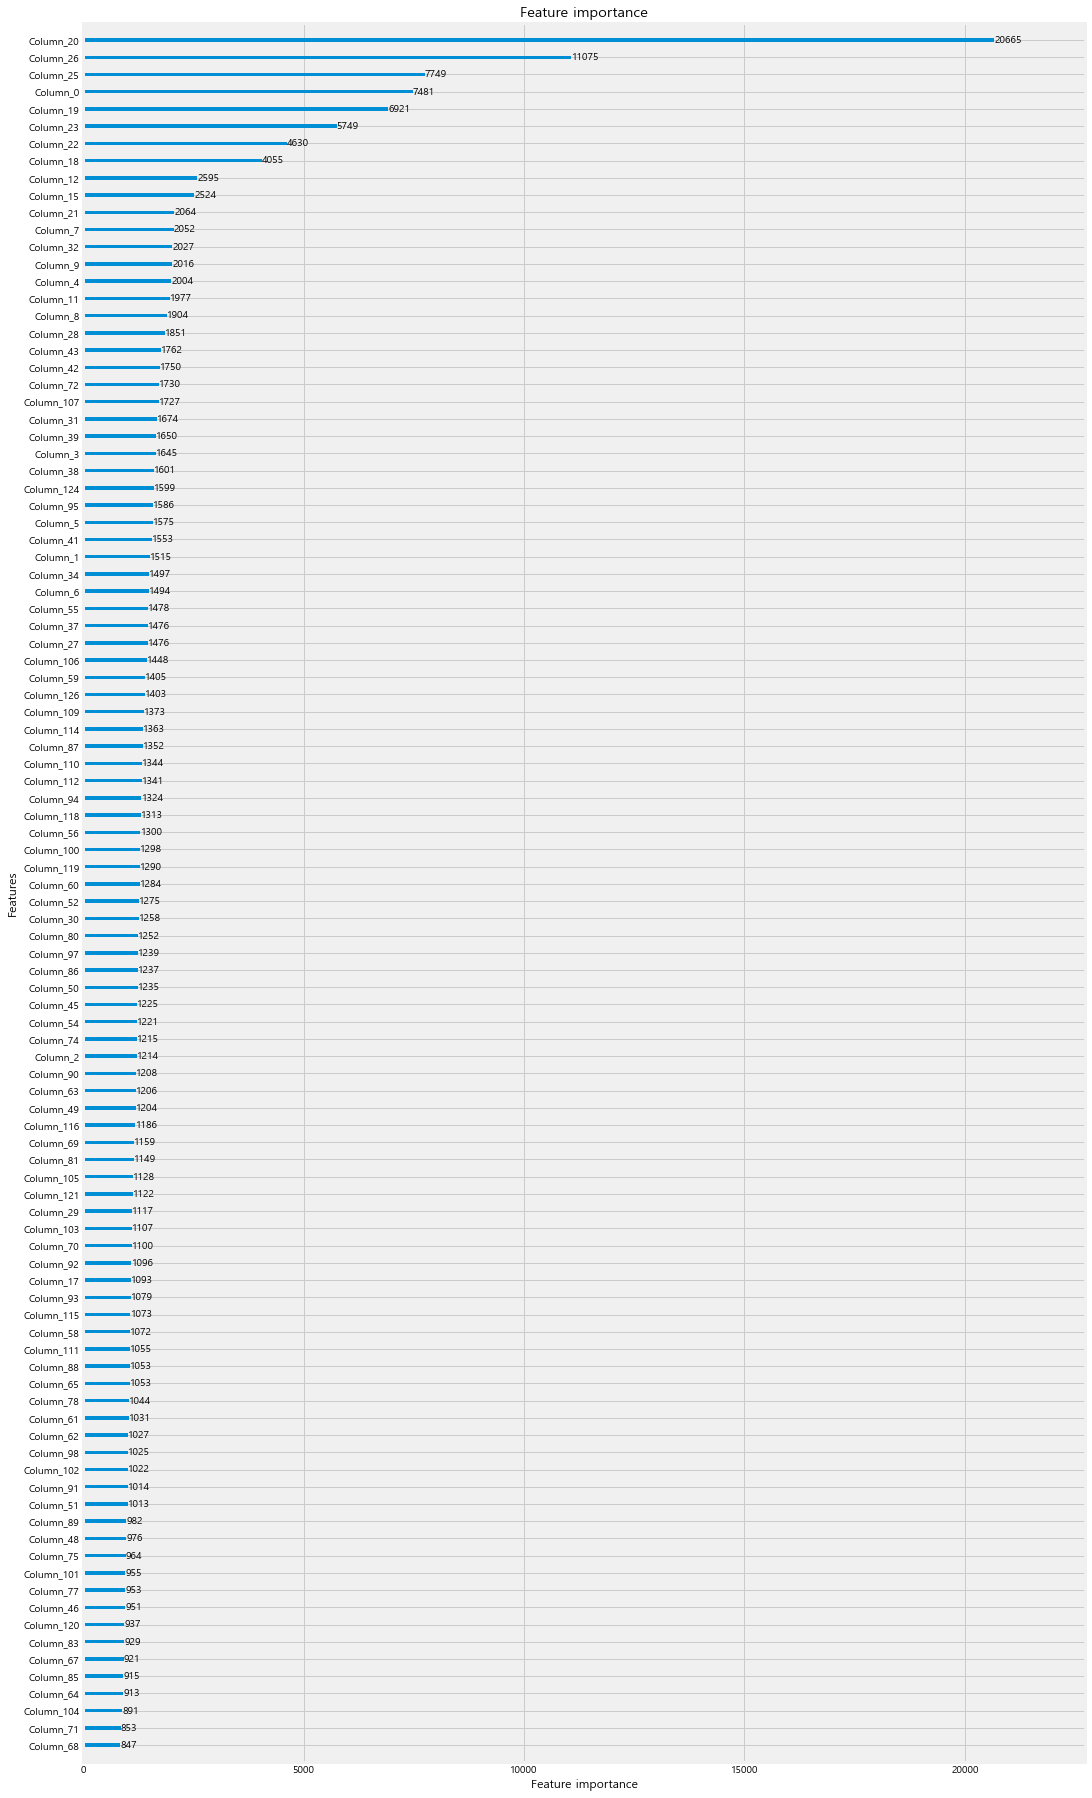

In [68]:
from lightgbm import plot_importance

plot_importance(lgb, figsize=(16, 32), max_num_features=100)

## submission

In [329]:
submission['pred'] = cb_pred

In [330]:
submission['pred'] = submission['pred'].apply(lambda x : 1 if x >=0.5 else 0)

In [331]:
submission['pred'].value_counts()
# 251개 - 0.72
# 330개 - 0.82369
# 344개 - 0.79
# 334개 - 

0    3910
1     334
Name: pred, dtype: int64

In [332]:
submission['pred'] = cb_pred
submission = submission.set_index('SEQ')
submission

,pred
SEQ,
T54370,0.002753
T47892,0.366382
T56637,0.124016
T45487,0.000809
T41995,0.013616
...,...
T31589,0.084627
T36236,0.000692
T34729,0.398240


In [333]:
submission.to_csv('submission/1122_cb_gr_5fold_ft_fs_pyeong.csv')

<AxesSubplot:>

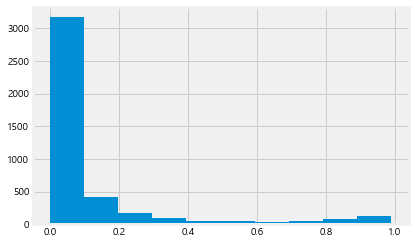

In [334]:
submission['pred'].hist()